In [99]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [33]:
# Stock Price Prediction with LSTM
# ==================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math
import datetime as dt
import talib
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [37]:
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    print(f"Downloaded {len(stock_data)} records of {ticker} data")
    return stock_data



In [39]:
def add_technical_indicators(df):
    close = df['Close'].to_numpy().flatten()  # Ensures 1D array

    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['SMA_20'] = talib.SMA(close, timeperiod=20)
    df['SMA_50'] = talib.SMA(close, timeperiod=50)
    df['EMA_20'] = talib.EMA(close, timeperiod=20)

    macd, macd_signal, macd_hist = talib.MACD(close)
    df['MACD'] = macd
    df['MACD_signal'] = macd_signal

    upper, middle, lower = talib.BBANDS(close, timeperiod=20)
    df['BB_upper'] = upper
    df['BB_middle'] = middle
    df['BB_lower'] = lower

    df.dropna(inplace=True)
    return df


In [41]:
def prepare_data_for_lstm(df, feature_columns, target_column, sequence_length=60, split_ratio=0.8):
    data_features = df[feature_columns].values
    data_target = df[target_column].values.reshape(-1, 1)
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    data_features_scaled = scaler_x.fit_transform(data_features)
    data_target_scaled = scaler_y.fit_transform(data_target)
    X, y = [], []
    for i in range(sequence_length, len(data_features_scaled)):
        X.append(data_features_scaled[i-sequence_length:i])
        y.append(data_target_scaled[i])
    X, y = np.array(X), np.array(y)
    train_size = int(len(X) * split_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    return X_train, y_train, X_test, y_test, scaler_x, scaler_y


In [43]:
def build_lstm_model(input_shape, lstm_units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [45]:
def train_lstm_model(model, X_train, y_train, epochs=50, batch_size=32, validation_split=0.1):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_split=validation_split, callbacks=[early_stopping], verbose=1)
    return history


In [97]:
def evaluate_model(model, X_test, y_test, scaler_y):
    predictions = model.predict(X_test)
    predictions_original = scaler_y.inverse_transform(predictions)
    y_test_original = scaler_y.inverse_transform(y_test)
    mse = mean_squared_error(y_test_original, predictions_original)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test_original, predictions_original)
    r2 = r2_score(y_test_original, predictions_original)
    print('Model Evaluation Metrics:')
    print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')
    return predictions_original, y_test_original, {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}


In [49]:
def plot_predictions(y_true, y_pred, title='Stock Price Prediction'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


In [51]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [53]:
def forecast_future_prices(model, last_sequence, scaler_x, scaler_y, n_steps=30):
    future_predictions = []
    current_sequence = last_sequence.copy()
    n_features = current_sequence.shape[2]
    for _ in range(n_steps):
        pred = model.predict(current_sequence)[0, 0]
        future_predictions.append(pred)
        next_input = np.zeros((1, 1, n_features))
        next_input[0, 0, 0] = pred
        for j in range(1, n_features):
            next_input[0, 0, j] = current_sequence[0, -1, j]
        current_sequence = np.append(current_sequence[:, 1:, :], next_input, axis=1)
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler_y.inverse_transform(future_predictions)


In [79]:
def plot_forecast(historical, forecasted, title='Forecast'):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(historical)), historical, label='Historical')
    plt.plot(range(len(historical), len(historical) + len(forecasted)), forecasted, label='Forecast')
    plt.axvline(x=len(historical) - 1, color='green', linestyle='--', label='Forecast Start')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()



[*********************100%***********************]  1 of 1 completed

Downloaded 1854 records of AAPL data
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1854 entries, 2018-01-02 to 2025-05-16
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1854 non-null   float64
 1   (High, AAPL)    1854 non-null   float64
 2   (Low, AAPL)     1854 non-null   float64
 3   (Open, AAPL)    1854 non-null   float64
 4   (Volume, AAPL)  1854 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 86.9 KB
None
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2018-01-02  40.426830  40.436220  39.722775  39.933994  102223600
2018-01-03  40.419781  40.964251  40.356418  40.490187  118071600
2018-01-04  40.607544  40.710806  40.384594  40.492547   89738400
2018-01-05  41.069866  41.156698  40.612231  40.703758   94640000
2018-0

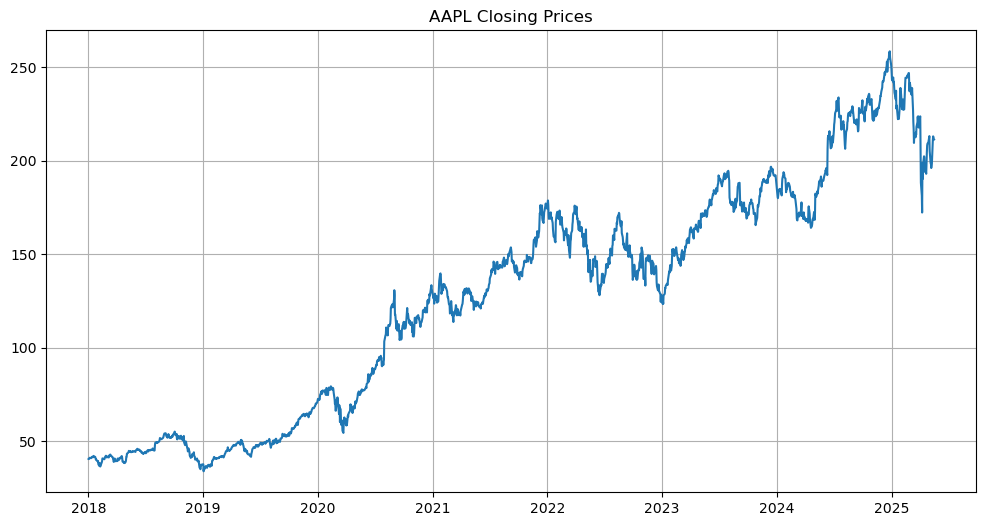

Training data shape: (1396, 60, 7)
Testing data shape: (349, 60, 7)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,701 (483.21 KB)

 Trainable params: 123,701 (483.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0369 - val_loss: 0.0031
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0021 - val_loss: 7.9294e-04
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0019 - val_loss: 4.0100e-04
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0013 - val_loss: 7.1210e-04
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 

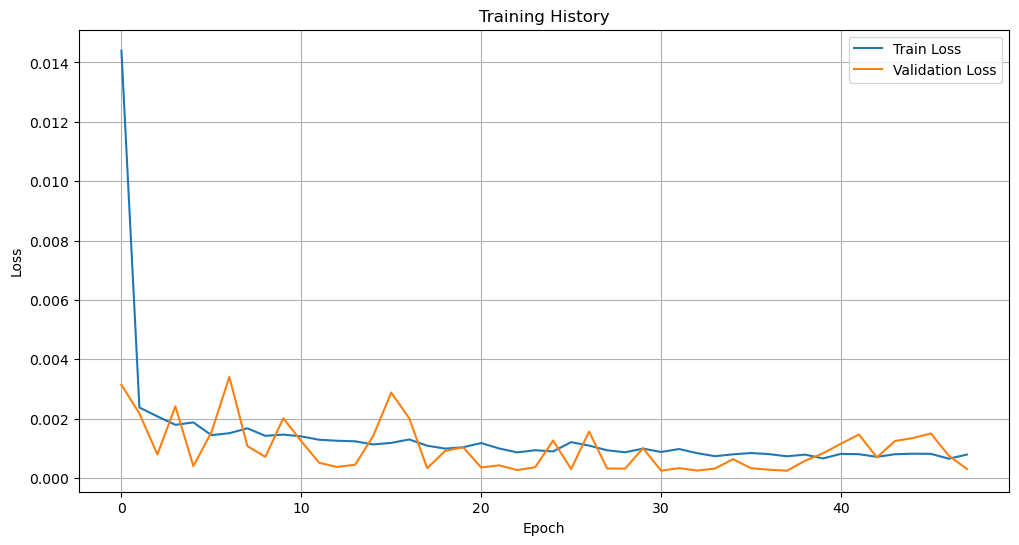

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Model Evaluation Metrics:
MSE: 57.3739, RMSE: 7.5746, MAE: 6.0116, R2: 0.9042


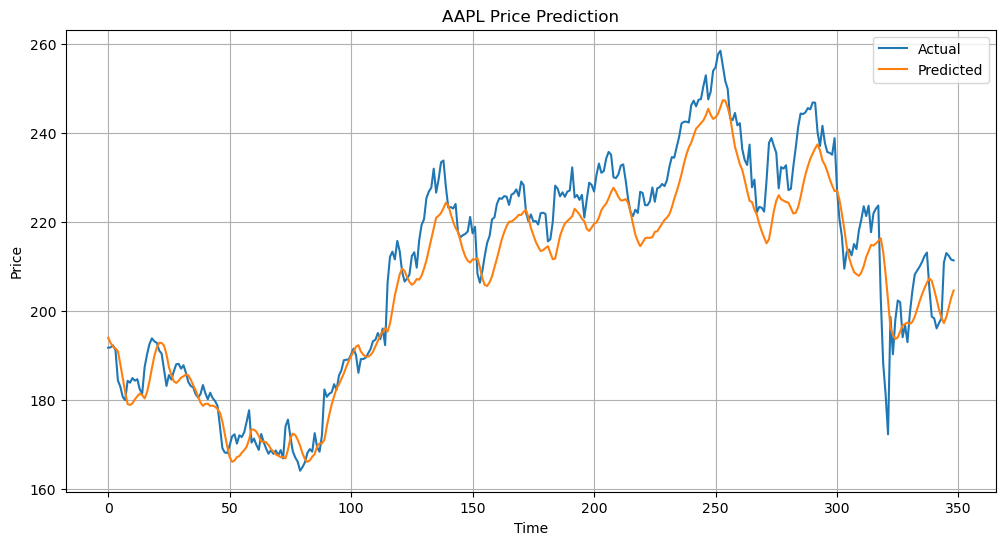

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

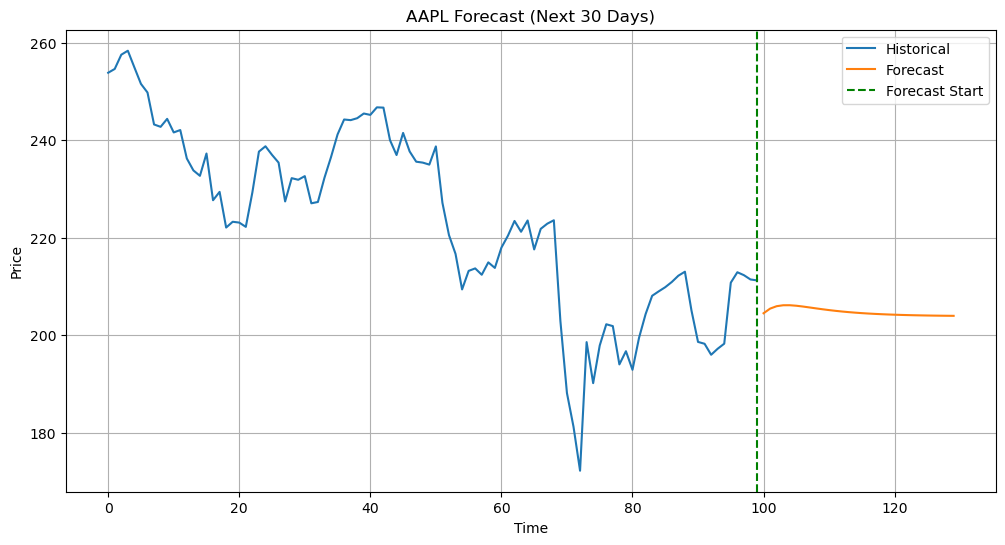

Model saved as 'my_model.keras'


In [103]:
if __name__ == "__main__":
    ticker = 'AAPL'
    start_date = '2018-01-01'
    end_date = dt.datetime.now().strftime('%Y-%m-%d')
    sequence_length = 60

    df = fetch_stock_data(ticker, start_date, end_date)
    print(df.info())
    print(df.head())

    plt.figure(figsize=(12, 6))
    plt.plot(df['Close'])
    plt.title(f'{ticker} Closing Prices')
    plt.grid(True)
    plt.show()

    df = add_technical_indicators(df)
    feature_columns = ['Close', 'RSI', 'SMA_20', 'EMA_20', 'MACD', 'BB_upper', 'BB_lower']
    target_column = 'Close'

    X_train, y_train, X_test, y_test, scaler_x, scaler_y = prepare_data_for_lstm(
        df, feature_columns, target_column, sequence_length)

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model(input_shape, lstm_units=100, dropout_rate=0.3)
    model.summary()

    history = train_lstm_model(model, X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

    plot_training_history(history)

    predictions, actual, metrics = evaluate_model(model, X_test, y_test, scaler_y)

    plot_predictions(actual, predictions, title=f'{ticker} Price Prediction')

    last_sequence = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])
    future_prices = forecast_future_prices(model, last_sequence, scaler_x, scaler_y, n_steps=30)

    historical_prices = df[target_column][-100:].values
    plot_forecast(historical_prices, future_prices.flatten(), title=f'{ticker} Forecast (Next 30 Days)')

    model.save('my_model.keras')
    print("Model saved as 'my_model.keras'")


In [93]:
def create_trading_strategy(actual_prices, predicted_prices, initial_capital=34000):
    """
    Create a simple trading strategy based on predictions
    
    Parameters:
    actual_prices (array): Actual stock prices
    predicted_prices (array): Predicted stock prices
    initial_capital (float): Initial investment capital
    
    Returns:
    DataFrame: Trading decisions and portfolio value over time
    """
    # Ensure inputs are 1D
    actual_prices = np.array(actual_prices).flatten()
    predicted_prices = np.array(predicted_prices).flatten()

    trading_df = pd.DataFrame({
        'Actual': actual_prices,
        'Predicted': predicted_prices
    })

    # Calculate direction of price movement
    trading_df['Actual_Direction'] = np.where(
        trading_df['Actual'].shift(-1) > trading_df['Actual'], 1, -1
    )
    trading_df['Predicted_Direction'] = np.where(
        trading_df['Predicted'].shift(-1) > trading_df['Predicted'], 1, -1
    )

    # Generate trading signals (1 for buy, -1 for sell)
    trading_df['Position'] = trading_df['Predicted_Direction'].shift(1)
    trading_df['Position'].fillna(0, inplace=True)
    trading_df['Position'] = trading_df['Position'].astype(int)

    # Calculate returns
    trading_df['Market_Return'] = trading_df['Actual'].pct_change() * 100
    trading_df['Strategy_Return'] = trading_df['Position'] * trading_df['Market_Return']

    # Cumulative returns
    trading_df['Cumulative_Market_Return'] = (1 + trading_df['Market_Return'] / 100).cumprod()
    trading_df['Cumulative_Strategy_Return'] = (1 + trading_df['Strategy_Return'] / 100).cumprod()

    # Portfolio value over time
    trading_df['Market_Portfolio'] = initial_capital * trading_df['Cumulative_Market_Return']
    trading_df['Strategy_Portfolio'] = initial_capital * trading_df['Cumulative_Strategy_Return']

    return trading_df


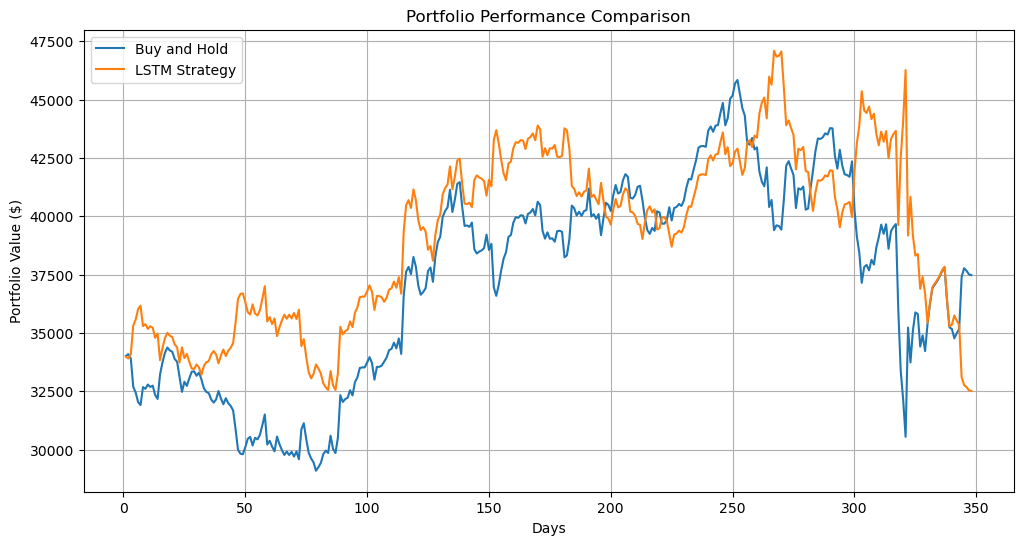


Trading Strategy Performance:
Initial Capital: $34000.00
Final Value (Buy and Hold): $37479.62 (Return: 10.23%)
Final Value (LSTM Strategy): $32514.51 (Return: -4.37%)


In [101]:
# Execute trading strategy 
trading_results = create_trading_strategy(actual, predictions)

# Plot portfolio performance
plt.figure(figsize=(12, 6))
plt.plot(trading_results['Market_Portfolio'], label='Buy and Hold')
plt.plot(trading_results['Strategy_Portfolio'], label='LSTM Strategy')
plt.title('Portfolio Performance Comparison')
plt.xlabel('Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# Print strategy performance metrics
initial_capital = 34000
final_market_value = trading_results['Market_Portfolio'].iloc[-1]
final_strategy_value = trading_results['Strategy_Portfolio'].iloc[-1]

print(f"\nTrading Strategy Performance:")
print(f"Initial Capital: ${initial_capital:.2f}")
print(f"Final Value (Buy and Hold): ${final_market_value:.2f} (Return: {(final_market_value/initial_capital - 1)*100:.2f}%)")
print(f"Final Value (LSTM Strategy): ${final_strategy_value:.2f} (Return: {(final_strategy_value/initial_capital - 1)*100:.2f}%)")


In [109]:

# Verify the model file exists
import os
if os.path.exists('my_model.keras'):
    print("Model file exists")
else:
    print("Model file not found - run training first")

Model file exists


In [111]:
pip install streamlit yfinance pandas numpy matplotlib tensorflow scikit-learn TA-Lib


Note: you may need to restart the kernel to use updated packages.


In [115]:
model.save('my_model.keras')
print("\nModel saved as 'my_model.keras'")

# Verify the file exists
import os
if os.path.exists('stock_lstm_model.h5'):
    print("✅ Model file exists and is ready for the Streamlit app")
else:
    print("❌ Model file not found. Make sure to run the training code first.")


Model saved as 'my_model.keras'
✅ Model file exists and is ready for the Streamlit app


In [121]:
with open('stock_prediction_app.py', 'w') as f:
    f.write('''
import streamlit as st
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import talib

# Load the model
@st.cache_resource
def load_lstm_model():
    return load_model('stock_lstm_model.h5')

# Function to fetch stock data
@st.cache_data
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Add technical indicators function
def add_technical_indicators(df):
    # Calculate RSI (Relative Strength Index)
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
    
    # Calculate Simple Moving Averages
    df['SMA_20'] = talib.SMA(df['Close'], timeperiod=20)
    df['SMA_50'] = talib.SMA(df['Close'], timeperiod=50)
    
    # Calculate Exponential Moving Averages
    df['EMA_20'] = talib.EMA(df['Close'], timeperiod=20)
    
    # Calculate MACD
    macd, macd_signal, macd_hist = talib.MACD(df['Close'])
    df['MACD'] = macd
    df['MACD_signal'] = macd_signal
    
    # Calculate Bollinger Bands
    upper, middle, lower = talib.BBANDS(df['Close'], timeperiod=20)
    df['BB_upper'] = upper
    df['BB_middle'] = middle
    df['BB_lower'] = lower
    
    # Drop NaN values
    df.dropna(inplace=True)
    
    return df

# Prepare data for prediction
def prepare_prediction_data(df, feature_columns, sequence_length=60):
    data_features = df[feature_columns].values
    
    # Scale the features
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_features)
    
    # Create the most recent sequence
    X_recent = []
    X_recent.append(data_scaled[-sequence_length:])
    X_recent = np.array(X_recent)
    
    return X_recent, scaler

# Streamlit app
st.title('Stock Price Prediction Dashboard')

# Sidebar inputs
st.sidebar.header('User Input Parameters')
ticker = st.sidebar.text_input('Stock Ticker', 'AAPL')
start_date = st.sidebar.date_input('Start Date', dt.date(2018, 1, 1))
end_date = st.sidebar.date_input('End Date', dt.date.today())
prediction_days = st.sidebar.slider('Future Prediction Days', 1, 90, 30)

# Load data
try:
    df = fetch_stock_data(ticker, start_date, end_date)
    
    # Display raw data
    st.subheader('Raw Stock Data')
    st.write(df.tail())
    
    # Plot close price
    st.subheader('Close Price History')
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df['Close'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.grid(True)
    st.pyplot(fig)
    
    # Add technical indicators
    df_with_indicators = add_technical_indicators(df.copy())
    
    # Display technical indicators
    st.subheader('Technical Indicators')
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Plot price and moving averages
    ax1.plot(df_with_indicators['Close'], label='Close')
    ax1.plot(df_with_indicators['SMA_20'], label='SMA 20')
    ax1.plot(df_with_indicators['SMA_50'], label='SMA 50')
    ax1.plot(df_with_indicators['EMA_20'], label='EMA 20')
    ax1.set_title('Price and Moving Averages')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # Plot RSI
    ax2.plot(df_with_indicators['RSI'], color='purple')
    ax2.axhline(70, color='red', linestyle='--', alpha=0.5)
    ax2.axhline(30, color='green', linestyle='--', alpha=0.5)
    ax2.set_title('RSI')
    ax2.set_ylabel('RSI Value')
    ax2.grid(True)
    
    # Plot MACD
    ax3.plot(df_with_indicators['MACD'], label='MACD')
    ax3.plot(df_with_indicators['MACD_signal'], label='Signal')
    ax3.set_title('MACD')
    ax3.set_ylabel('MACD Value')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    st.pyplot(fig)
    
    # Make prediction when button is clicked
    if st.button('Predict Future Prices'):
        # Load the model
        model = load_lstm_model()
        
        # Prepare recent data for prediction
        feature_columns = ['Close', 'RSI', 'SMA_20', 'EMA_20', 'MACD', 'BB_upper', 'BB_lower']
        X_recent, scaler = prepare_prediction_data(df_with_indicators, feature_columns)
        
        # Predict future prices (simple approach)
        last_price = df['Close'].iloc[-1]
        future_prices = [last_price]
        
        current_batch = X_recent.copy()
        for i in range(prediction_days):
            # Predict next price
            pred = model.predict(current_batch)
            
            # Scale the prediction back
            prediction_array = np.zeros((1, len(feature_columns)))
            prediction_array[0, 0] = pred[0, 0]  # Set the predicted closing price
            
            # For simplicity, we're keeping other features constant
            pred_price = scaler.inverse_transform(prediction_array)[0, 0]
            future_prices.append(pred_price)
            
            # Update the batch for next prediction (simplified)
            current_batch = np.roll(current_batch, -1, axis=1)
            current_batch[0, -1, 0] = pred[0, 0]  # Replace the last element with our prediction
        
        # Plot the prediction
        future_dates = pd.date_range(start=df.index[-1], periods=prediction_days+1)[1:]
        historical_dates = df.index[-60:]  # Last 60 days
        
        st.subheader('Future Price Prediction')
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(historical_dates, df['Close'][-60:], label='Historical Prices')
        ax.plot(future_dates, future_prices[1:], color='red', label='Predicted Prices')
        ax.axvline(x=df.index[-1], color='green', linestyle='--', label='Today')
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        ax.set_title(f'{ticker} Stock Price Prediction')
        ax.legend()
        ax.grid(True)
        plt.xticks(rotation=45)
        st.pyplot(fig)
        
        # Display prediction summary
        st.subheader('Prediction Summary')
        prediction_summary = pd.DataFrame({
            'Date': future_dates,
            'Predicted Price': future_prices[1:]
        })
        st.write(prediction_summary)
        
        # Calculate and display potential return
        current_price = df['Close'].iloc[-1]
        predicted_price = future_prices[-1]
        potential_return = (predicted_price / current_price - 1) * 100
        
        st.subheader('Investment Potential')
        col1, col2, col3 = st.columns(3)
        col1.metric('Current Price', f'${current_price:.2f}')
        col2.metric('Predicted Price', f'${predicted_price:.2f}')
        col3.metric('Potential Return', f'{potential_return:.2f}%')
        
except Exception as e:
    st.error(f"Error: {e}")
    st.write("Please make sure you've entered a valid stock ticker and date range.")
''')

print("✅ Streamlit app file created: stock_prediction_app.py")

# Method 2: Launch Streamlit app from Jupyter
# Note: This will launch a new process
import os
print("\nLaunching Streamlit app...")
print("The app will open in a new browser window/tab.")
print("To stop the app, press Ctrl+C in the Jupyter terminal")
print("or close this notebook.")

# Launch the Streamlit app
!streamlit run stock_prediction_app.py

✅ Streamlit app file created: stock_prediction_app.py

Launching Streamlit app...
The app will open in a new browser window/tab.
To stop the app, press Ctrl+C in the Jupyter terminal
or close this notebook.
zsh:1: command not found: streamlit
